In [122]:
print("Hello World!!!")

Hello World!!!


In [123]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [124]:
fetch_housing_data()

In [125]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [126]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [127]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [128]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [129]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


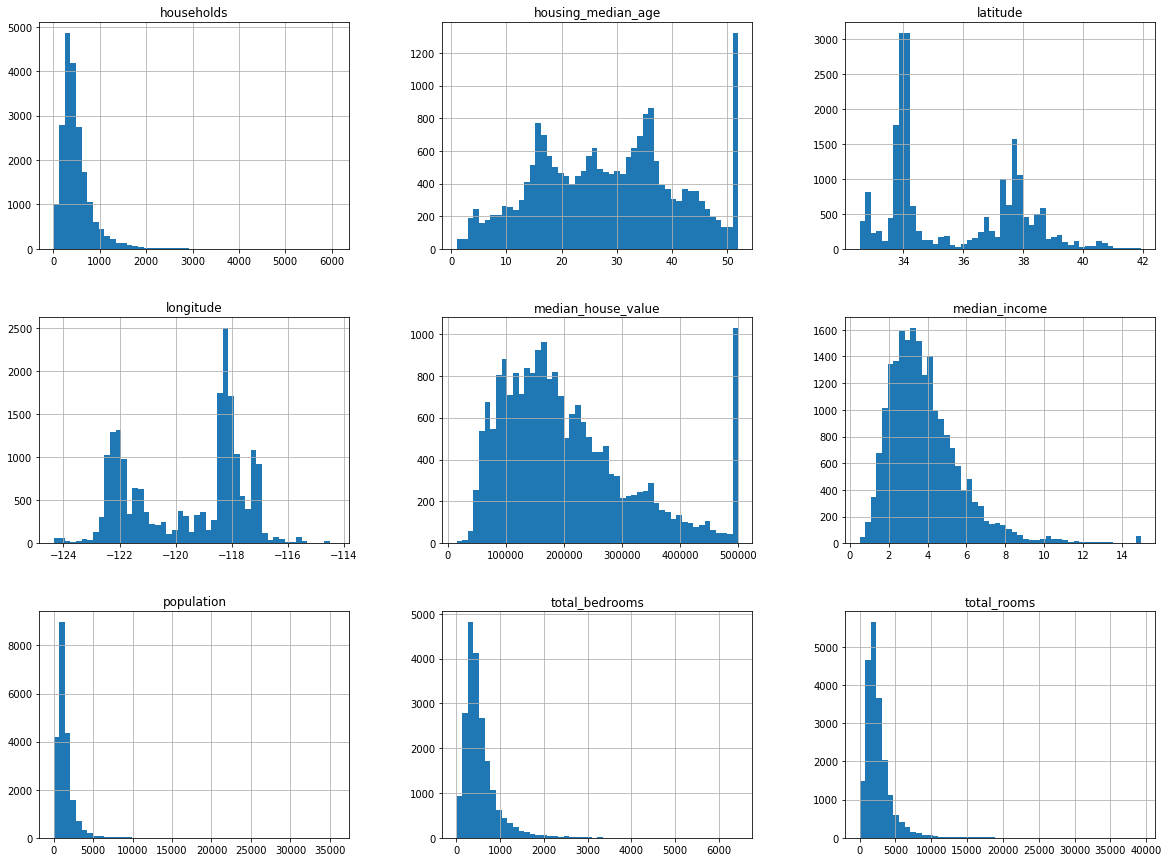

In [130]:
#only in Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [131]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [132]:
np.random.seed(42)
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set)," train +", len(test_set), "test")

(16512, ' train +', 4128, 'test')


In [133]:
print("result", len(np.random.permutation(len(housing))[11:20]))

('result', 9)


In [134]:
'''
The train_set and test_set will produce different data during each runs.
Overtime the algorith would see all of the data. This should be avoided.

One solution is to save the test set on the first run and use it in subsequent runs

Another option is set the seed value for random generators by calling
np.random.seed(42)
    
before calling
    np.random.permutation()
doing so it will generate same shuffled indices

But both solutions will be next time you fetch an updated data set

Another common soultion would be to use unique identifier of each instance to decide whether that would go
into the training set.

'''
import hashlib

def test_set_check(identifier, test_ratio, hash_method):
    hashed_identifier = hash_method(np.int64(identifier)).digest()        
    return bytearray(hashed_identifier)[-1] < 256 * test_ratio    

def split_train_test_by_id(data, test_ratio, id_column, hash_method=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash_method))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [135]:
# the housing data set doesn't have an unique identifier column, let's generate one
housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [136]:
'''
if row index is used as an unique identifier then we have to make sure new data set is always
appended to the end of the list and no row is ever deleted.

since this is not possible, we are going to generate unique id based on existing data.
'''
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [137]:
# the method "split_train_test" we wrote earlier is also available from Scikit-Learn.
# here setting random_state is equivalent to setting random seed earlier
from sklearn.model_selection import train_test_split
train_set, test_test = train_test_split(housing, test_size=0.2, random_state=42)

In [138]:
# test set must be representative of full data.
# example, if US population composed of 51.3% of female and 48.7% of male
# then test set must must maintain ratio of 513 female and 487 male
# this is called "stratified sampling"
# then this data is divided into homogeneous subgroups called "strata"
# in stratum every strata must have sufficient samples meaning not so large or not so small rather
# it should be large enough

# Suppose we see median_income is such an important parameter to calculate median housing prices
# then we will have to ensure that test set is representative of whole data set based on various categories of
# median income.
# for that we need to calculate income category based on median income
# while calculating the categories we should not be left with too many categories
# so we are deviding the median_income by 1.5 to minimze the categories and rounding up using ceil
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


In [139]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [144]:
# let's see the proportion of each housing category in the whole data set
def income_cat_proportions(data):
    return data["income_cat"].value_counts()/len(data)
income_cat_proportions(housing) * 100

3.0    35.058140
2.0    31.884690
4.0    17.630814
5.0    11.443798
1.0     3.982558
Name: income_cat, dtype: float64

In [153]:
# Let's generate new test, train data using stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strata_train_set = housing.loc[train_index]
    strata_test_set = housing.loc[test_index]

In [145]:
# let's measure the proportions of income_cat in the test set
income_cat_proportions(strata_test_set) * 100

3.0    35.053295
2.0    31.879845
4.0    17.635659
5.0    11.458333
1.0     3.972868
Name: income_cat, dtype: float64

In [147]:
# as wee the strata samples income category proportions are almost similar to that of what was acquired from
# full data set.
# thanks to stratified sampling

# how about the proportions in test set generated using random sampling
train_set, test_set = split_train_test(housing, 0.2)
income_cat_proportions(test_set) * 100

## As you see the test set from random sampling is more diversed than that of statified sampling's

3.0    35.101744
2.0    31.855620
4.0    17.562984
5.0    11.749031
1.0     3.730620
Name: income_cat, dtype: float64

In [150]:
# Let's calculate and compare error percentage of Overall's, Random's and Stratified's
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Random": income_cat_proportions(test_set),
    "Stratified": income_cat_proportions(strata_test_set),
})
compare_props["Random Error %"] = 100*(compare_props["Random"]/compare_props["Overall"])-100
compare_props["Stratified Error %"] = 100*(compare_props["Stratified"]/compare_props["Overall"])-100

compare_props
#samples obtained using stratified samples has almost negligible errors

,Overall,Random,Stratified,Random Error %,Stratified Error %
3.0,0.350581,0.351017,0.350533,0.124378,-0.013820
2.0,0.318847,0.318556,0.318798,-0.091172,-0.015195
4.0,0.176308,0.175630,0.176357,-0.384721,0.027480
5.0,0.114438,0.117490,0.114583,2.667231,0.127011
1.0,0.039826,0.037306,0.039729,-6.326034,-0.243309


In [154]:
# let's remove the income_cat from the obtained data to restore to its orginal state
for set_ in (strata_train_set, strata_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [155]:
# so far we have taken a quick glance at the data set to understand the various features of it
# The next goal is to go in-depth.
# before that we will keep the test_set aside and only explore train_set
# to make sure we don't hamper the actual train_set we will make a copy of it

housing = strata_train_set.copy()

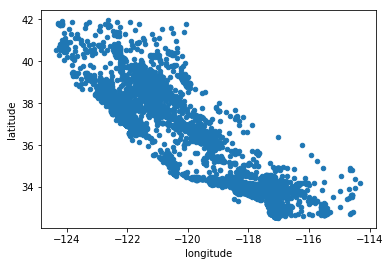

In [156]:
housing.plot(kind="scatter", x="longitude", y="latitude")